<a href="https://colab.research.google.com/github/Emanalytics7/Deeplearning-from-scratch/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Digit Recognition using MNIST + Pytorch**


*if you wanna know how much you know...teach someone.. so here i'm explaining things to YOU..  :)*

In [ ]:
import torch
import numpy as np
from torchvision import datasets, transforms
from pathlib import Path
import os
import torch.nn as nn
from torchsummary import summary
import  torch.optim as optim
from time import time

In [ ]:
p = Path('data')
p.mkdir(exist_ok=True)

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, ), (0.5,))])

In [ ]:
tdataset = datasets.MNIST(p, train=True, download=True, transform=transform)
vdataset = datasets.MNIST(p, train=False, download=True, transform=transform)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 47.8MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.56MB/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 13.1MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.98MB/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
len(tdataset), len(vdataset)

(60000, 10000)

In [ ]:
trainlr = torch.utils.data.DataLoader(tdataset, batch_size=64, shuffle=True)
valr = torch.utils.data.DataLoader(vdataset, batch_size=64, shuffle=True)

In [ ]:
dataiter = iter(trainlr)
i, l = next(dataiter)
print(i.shape, l.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


In [ ]:
i[0].numpy().shape

(1, 28, 28)

In [ ]:
i[0].numpy().squeeze().shape

(28, 28)

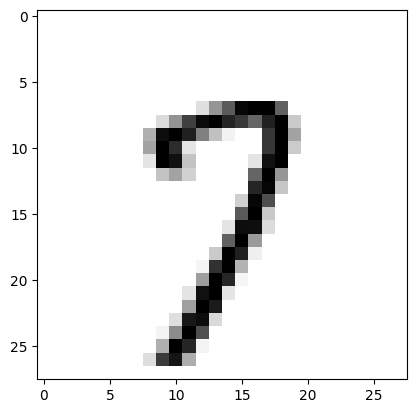

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(i[0].numpy().squeeze(), cmap='gray_r')

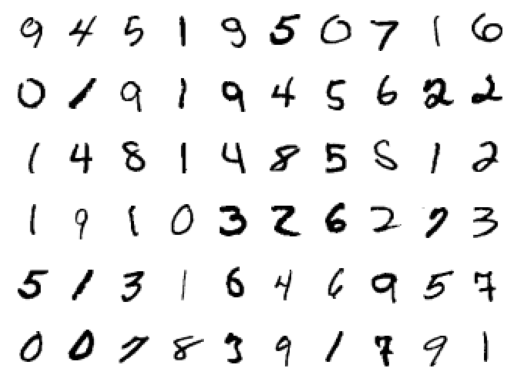

In [ ]:
f = plt.figure()
n = 60
for k in range(1, n + 1):
    plt.subplot(6, 10, k)
    plt.axis('off')
    plt.imshow(i[k].numpy().squeeze(), cmap='gray_r')

## **Simple FeedForward Network**

In [ ]:
class MNIST(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=10):
        super(MNIST, self).__init__()
        self.i = nn.Linear(input_size, hidden_size)
        self.ia = nn.ReLU()
        self.h = nn.Linear(hidden_size, hidden_size)
        self.ha = nn.ReLU()
        self.o = nn.Linear(hidden_size, output_size)
        self.oa = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.ia(self.i(x))
        x = self.ha(self.h(x))
        x = self.oa(self.o(x))
        return x

## ***But why-not softmax ? and what the heck is this logsoftmax :|***

we started from pytorch and ends up in math ..

**What is even softmax activation function?**

> Softmax take a vector of raw output(logits) and convert them into probabilities. these probabilities are all positive and sum up to 1

 here's the formula:

 $$
 softmax(x_i) = \frac{e^{x_i}}{Σ{e^{x_{j}}}}
 $$

**LOGITS** : these are basically the raw confidence scores from the output layer before passing through the activation function

these usually looks like this:

`logits = [50,55, 20, 10, 53 ,64]`

so if we calcualte the exponents here like this

$e^{50}, e^{55}$


**the value of $𝑒^{55}$ is very large (approximately $5.9×10^{23}$ ) which can lead to overflow issues in calculations if the values exceed the maximum number that can be represented in floatingpoint arithmetic**

##**resulting Probabilities**:

If we compute the softmax normally:  

For class 0 (logit = 50):  
$$  
P_0 = \frac{e^{50}}{e^{50} + e^{55} + \ldots} \approx \frac{5.2 \times 10^{21}}{5.9 \times 10^{23}} \approx 0.088  
$$  

For class 1 (logit = 55):  
$$  
P_1 = \frac{e^{55}}{e^{50} + e^{55} + \ldots} \approx \frac{5.9 \times 10^{23}}{5.9 \times 10^{23}} = 1  
$$


> *e very small values of the other classes (e.g., P 0, P 2
, etc.) may become so small that they round down to zero in floating point representation. which  means the model effectively only predicts the class with the highest logit, losing all information about the other classes.*


## **how the log Softmax helps**

instead of calculating  $e^{x_j}$ directly we can subtract the maximum logit (55 in this case) from each logit before applying the softmax formula.

this prevents large exponentials:  

$$  
\text{logsoftmax}(x_i) = x_i - \log\left(\sum_j e^{x_j - \max(x)}\right)  
$$  

The logits would then be:  

Logits adjusted:    
`[50-55, 55-55, 53-55, 52-55, 48-55, 49-55, 50-55, 51-55, 52-55, 53-55] `
`[-5, 0, -2, -3, -7, -6, -5, -4, -3, -2]`

## **Resutling Probs**

For Class 1 (the highest logit):  
$$  
\text{logsoftmax}(55) = 0  
$$  

For Class 0:  
$$  
\text{logsoftmax}(50) = -5  
$$  

the log probabilities will be negative values but they remain well within the limits of floating point representation which will going to preventing overflow

In [ ]:
model = MNIST(input_size=784, hidden_size=128)
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
              ReLU-2                  [-1, 128]               0
            Linear-3                  [-1, 128]          16,512
              ReLU-4                  [-1, 128]               0
            Linear-5                   [-1, 10]           1,290
        LogSoftmax-6                   [-1, 10]               0
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.45
Estimated Total Size (MB): 0.46
----------------------------------------------------------------


In [ ]:
criterion = nn.NLLLoss() ## negative log likelihood loss used for logsoftmax
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
time0 = time()
epochs = 15
for e in range(epochs):
    r = 0.0
    for i, l in trainlr:
        optimizer.zero_grad()
        output = model(i)
        loss = criterion(output, l)
        loss.backward()
        optimizer.step()
        r += loss.item()
    else:
        print('Epoch {} - Training loss: {}'.format(e, r / len(trainlr)))

print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 1.0250936779799238
Epoch 1 - Training loss: 0.37753917491321626
Epoch 2 - Training loss: 0.3208653716437979
Epoch 3 - Training loss: 0.28949061191793696
Epoch 4 - Training loss: 0.26401559396911023
Epoch 5 - Training loss: 0.24191181182956645
Epoch 6 - Training loss: 0.22272296089416882
Epoch 7 - Training loss: 0.2044416396999791
Epoch 8 - Training loss: 0.18885839214600098
Epoch 9 - Training loss: 0.17535823357821717
Epoch 10 - Training loss: 0.16293306595711374
Epoch 11 - Training loss: 0.15276957574937897
Epoch 12 - Training loss: 0.14279752941543994
Epoch 13 - Training loss: 0.13459175959952288
Epoch 14 - Training loss: 0.1262005584588501

Training Time (in minutes) = 4.994933370749155


## **Model in evaluation mode.. huh?**

* first if we have dropout layers(so no neurons are randomly turned off to prevent overfitting)
* batch normalization layers to use overall statistics from training instead of the statistics from the current batch

if we don't use `model.eval()` when testing our model, the results we get might be inaccurate because model is still acting as if it's in training mode

In [ ]:
model.eval()

MNIST(
  (i): Linear(in_features=784, out_features=128, bias=True)
  (ia): ReLU()
  (h): Linear(in_features=128, out_features=128, bias=True)
  (ha): ReLU()
  (o): Linear(in_features=128, out_features=10, bias=True)
  (oa): LogSoftmax(dim=1)
)

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for i, l in valr:
        o = model(i)
        _, y_hat = torch.max(o, 1) ## let me explain this thing below!
        total += l.size(0)
        correct += (y_hat == l).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on the validation set: {accuracy:.2f}%')

Accuracy on the validation set: 96.13%


let's say this is our output after the first batch ..

**o** = `[[2.0, 0.5, 1.0, 4.0, 0.2, 0.1, 1.5, 0.3, 0.0, 0.1],
     [0.1, 1.0, 0.3, 0.2, 0.0, 3.0, 0.5, 0.1, 0.4, 0.2],
     [1.0, 0.5, 3.5, 0.4, 0.0, 0.1, 2.0, 1.0, 0.2, 0.3]]`


* Row 1: The maximum value is `4.0` at index 3
* Row 2: The maximum value is `3.0` at index 5
* Row 3: The maximum value is `3.5` at index 2


When we call torch.max(o, 1), we get:

1. Maximum values:
`[4.0, 3.0, 3.5]`
2. Indices of the maximum values (what we care about): **y_hat** = `[3, 5, 2]`



---



---



## **Convolutional Neural Networks**